Trying to compare Yandex Vision and Face++ resoults
What left to do:
* Found how to save and read label with count of faces
* Count some data from the last block
* Try to make some plots
* Visualize it in streamlit
* Write beutiful README and push it to github

In [153]:
import base64
import json
import requests
import os
import re
import matplotlib.pyplot as plt

Constants:

In [154]:

YANDEX_URL = 'https://vision.api.cloud.yandex.net/vision/v1/batchAnalyze'
FACE_URL = 'https://api-us.faceplusplus.com/facepp/v3/detect'


with open('../yandex_tkn.txt', 'r', encoding='utf-8') as f:
    YANDEX_API_KEY = f.read()

with open('../faceplus_tkn.txt', 'r', encoding='utf-8') as f:
    FACE_API_KEY = f.read()

with open('../faceplus_secret.txt', 'r', encoding='utf-8') as f:
    FACE_API_SECRET = f.read()


YANDEX_HEADER = {"Authorization": f"Api-Key {YANDEX_API_KEY}"}

#faceplusplus requierse to send api key and secret with the image
#so i'll make it later

In this variables i'll keep count of detected faces

In [155]:
yandex_total_faces_count = 0
faceplus_total_faces_count = 0
total_faces_count = 0


#accurasy of every predict in procents
yandex_individual_accurasy = []
faceplus_individual_accurasy = []

Functions:

In [156]:
#taking image file in base64 encoding
#return count of people on the image
def yandex_request(image_b64):
    
    data_dict={"folderId":"b1gb2477drh0ivbugf0p", "analyze_specs": [{"content":image_b64.decode(), 
                "features":[{"type": "FACE_DETECTION"}], "mimeType":"image/jpeg"}]}
    
    response = requests.post(YANDEX_URL, json=data_dict, headers=YANDEX_HEADER)
    print(response)
    responce_data = response.json()

    #if no faces detected return  0
    if(responce_data['results'][0]['results'][0]['faceDetection'] == {}):   return 0

    #array of dicts(coordinates of bounding boxes)
    faces = responce_data['results'][0]['results'][0]['faceDetection']['faces']
    

    return len(faces)

In [157]:
#taking image file in base64 encoding
#return count of people on the image
def faceplus_request(image_b64):

    data_dict = {'api_key':FACE_API_KEY, 'api_secret':FACE_API_SECRET, "image_base64":image_b64}

    response = requests.post(FACE_URL, data=data_dict)

    response_data = json.loads(response.text)

    return response_data['face_num']


In [158]:
def get_total_faces_count(filename):
    match = re.search(r'\d{,2}', filename)
    return int(match[0])

Getting data from services:

In [159]:
dataset = sorted(os.listdir('data'), key=get_total_faces_count)

for filename in dataset:

    total_faces_count += get_total_faces_count(filename)


    with open(f'data/{filename}', 'rb') as img:

        image_b64 = base64.b64encode(img.read())
        
        #yandex detecting:
        faces_count = yandex_request(image_b64)
        print (f'Yndx: {faces_count} faces on {filename}')

        yandex_individual_accurasy.append(faces_count/get_total_faces_count(filename) * 100)
        print(f'Yndx accurasy on {filename} = {yandex_individual_accurasy[-1]}%')
        
        yandex_total_faces_count += faces_count


        #face++ detecting:
        faces_count = faceplus_request(image_b64)
        print(f'F++: {faces_count} faces on {filename}')
        
        faceplus_individual_accurasy.append(faces_count/get_total_faces_count(filename) * 100)
        print(f'F+ accurasy on {filename} = {faceplus_individual_accurasy[-1]}%')

        faceplus_total_faces_count += faces_count


print(  f'Yandex detected {yandex_total_faces_count} faces', 
        f'Face++ detected {faceplus_total_faces_count} face', 
        f'There\'re {get_total_faces_count(filename)} faces at all',
    sep='\n')

<Response [200]>
Yndx: 1 faces on 1_man.jpg
Yndx accurasy on 1_man.jpg = 100.0%
F++: 1 faces on 1_man.jpg
F+ accurasy on 1_man.jpg = 100.0%
<Response [200]>
Yndx: 1 faces on 1_man_in_facemask.jpg
Yndx accurasy on 1_man_in_facemask.jpg = 100.0%
F++: 1 faces on 1_man_in_facemask.jpg
F+ accurasy on 1_man_in_facemask.jpg = 100.0%
<Response [200]>
Yndx: 1 faces on 2_me.jpg
Yndx accurasy on 2_me.jpg = 50.0%
F++: 2 faces on 2_me.jpg
F+ accurasy on 2_me.jpg = 100.0%
<Response [200]>
Yndx: 1 faces on 3_day_of_death.jpg
Yndx accurasy on 3_day_of_death.jpg = 33.33333333333333%
F++: 2 faces on 3_day_of_death.jpg
F+ accurasy on 3_day_of_death.jpg = 66.66666666666666%
<Response [200]>
Yndx: 3 faces on 3_film.jpg
Yndx accurasy on 3_film.jpg = 100.0%
F++: 3 faces on 3_film.jpg
F+ accurasy on 3_film.jpg = 100.0%
<Response [200]>
Yndx: 3 faces on 4_brigade.jpg
Yndx accurasy on 4_brigade.jpg = 75.0%
F++: 4 faces on 4_brigade.jpg
F+ accurasy on 4_brigade.jpg = 100.0%
<Response [200]>
Yndx: 5 faces on 5_tr

Analysing data:
* Total accuracy = all detected faces / total count of faces
* Average accuracy:  $$\frac{\displaystyle\sum_{i = 1}^{n}C_i}{n}  \\
                        n  =  \textrm{dataset size}  \\ C_i =  \textrm{individual accurasy on the picture} $$



In [160]:
yandex_total_accuracy = yandex_total_faces_count / total_faces_count * 100
faceplus_total_accurasy = faceplus_total_faces_count / total_faces_count * 100
yandex_average_accuracy = 0
faceplus_average_accurasy = 0

yandex_average_accuracy = sum(yandex_individual_accurasy)/len(yandex_individual_accurasy)
faceplus_average_accurasy  = sum(faceplus_individual_accurasy)/len(faceplus_individual_accurasy)


print(f'Yndx total accuraсy = {yandex_total_accuracy}%', 
    f'Face++ total accuraсy = {faceplus_total_accurasy}%', 
    f'Yandex average accuracy = {yandex_average_accuracy}',
    f'Face++ average accuracy = {faceplus_average_accurasy}', sep='\n')



Yndx total accuraсy = 13.761467889908257%
Face++ total accuraсy = 87.1559633027523%
Yandex average accuracy = 46.52777777777777
Face++ average accuracy = 92.59920634920634


Plot

###### Detecting accuracy depends on the number of faces

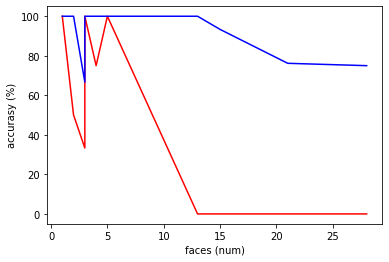

In [161]:
faces = len(os.listdir('data'))
x = sorted([get_total_faces_count(x) for x in os.listdir('data')])


yandex_individual_accurasy = [100.0, 100.0, 50.0, 33.33333333333333, 100.0, 75.0, 100.0, 0.0, 0.0, 0.0, 0.0, 0.0]

plt.plot(x, yandex_individual_accurasy, color='red')
plt.plot(x, faceplus_individual_accurasy, color = 'blue')

plt.xlabel('faces (num)')
plt.ylabel('accurasy (%)')

plt.show()




Red line - yandex accuracy

Blue line - Face++ accuracy